## Event camera demo
**By Cedric Scheerlinck**  
Tested on python3.7.5  
Description: load and visualize events from a small dataset.  
Based on https://github.com/cedric-scheerlinck/dvs_image_reconstruction


Note: If interact doesn't work, try enabling ipywidgets:  
```jupyter nbextension enable --py widgetsnbextension```  
and restarting jupyter notebook.

In [1]:
from ipywidgets import interact, fixed, interact_manual, FloatSlider, IntSlider
import math
%matplotlib notebook
from matplotlib import rc
rc('animation', html='jshtml')
import numpy as np

# local modules
from util import Timer, Event, normalize_image, animate, load_events, plot_3d, event_slice

In [2]:
def high_pass_filter(event_data, cutoff_frequency=5):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    events_per_frame = 2e4
    with Timer('Reconstruction'):
        time_surface = np.zeros((height, width), dtype=np.float32)
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        for i, e in enumerate(events):
            beta = math.exp(-cutoff_frequency * (e.t - time_surface[e.y, e.x]))
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p
            time_surface[e.y, e.x] = e.t
            if i % events_per_frame == 0:
                beta = np.exp(-cutoff_frequency * (e.t - time_surface))
                image_state *= beta
                time_surface.fill(e.t)
                image_list.append(np.copy(image_state))
    return animate(image_list, 'High Pass Filter')

def leaky_integrator(event_data, beta=1.0):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    events_per_frame = 2e4
    with Timer('Reconstruction (simple)'):
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        for i, e in enumerate(events):
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p
            if i % events_per_frame == 0:
                image_list.append(np.copy(image_state))
    fig_title = 'Direct Integration' if beta == 1 else 'Leaky Integrator'
    return animate(image_list, fig_title)


In [3]:
with Timer('Loading'):
    n_events = 5e5
    path_to_events = 'data/boxes_6dof/events.zip'
    event_data = load_events(path_to_events, n_events)        

Loading events...
width, height: 240, 180
Loaded 0.50M events
Loading: 1.22s


## Event point cloud

<span style="color:red">Red = ON event (+1),</span> <span style="color:blue">blue = OFF event (-1).</span>  
Click and drag the 3D plot to rotate it.

<IPython.core.display.Javascript object>


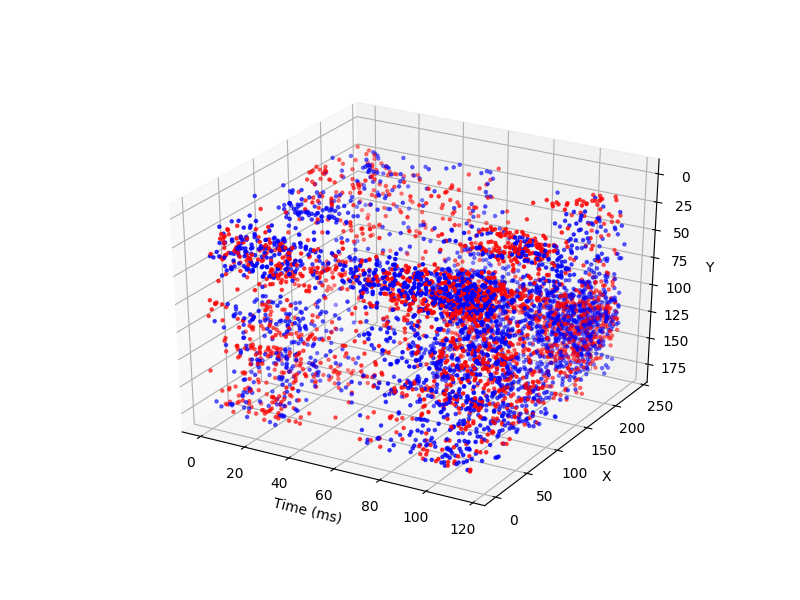

3D plot: 0.06s


In [4]:
with Timer('3D plot'):
    plot_3d(event_data, n_events=5e3)

## Event slice

Use the sliders to visualize a slice of events within a time window.

In [5]:
interact(event_slice, event_data=fixed(event_data),
         start=FloatSlider(min=0, max=1, step=0.01,continuous_update=False),
         duration_ms=IntSlider(value=50, min=0, max=500, step=1, continuous_update=False));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='start', max=1.0, step=0.01)…

## Image reconstruction
Run the cell, then click ```Run Interact``` and wait for the animation to appear to see the result.  
Use the slider then click ```Run Interact``` again to try different settings.

### Leaky integrator
Equation: $L^{k+1}(x, y) = \beta L^k(x, y) + p,\ \beta \in [0, 1],\ p \in \{-1, 1\}$, where $L$ is the log image intensity and $p$ is the event polarity.

#### Set ```beta = 1``` for direct integration. Try lowering beta to see what happens.

In [6]:
interact_manual(leaky_integrator, event_data=fixed(event_data), beta=(0, 1, 0.01));

interactive(children=(FloatSlider(value=1.0, description='beta', max=1.0, step=0.01), Button(description='Run …

### High pass filter
Below is the high pass filter as described in: https://cedric-scheerlinck.github.io/files/2018_scheerlinck_continuous-time_intensity_estimation.pdf  
Equation: $L^{k+1}(x, y) = \exp(-\alpha \Delta t) L^k(x, y) + p$, where $\alpha$ is the cutoff frequency and $\Delta t$ is the time since the last event at the same pixel.

In [7]:
interact_manual(high_pass_filter, event_data=fixed(event_data), cutoff_frequency=(0, 20, 0.01));

interactive(children=(FloatSlider(value=5.0, description='cutoff_frequency', max=20.0, step=0.01), Button(desc…